<a href="https://colab.research.google.com/github/AmanPriyanshu/Discussing_Learning/blob/master/NeuralNetFiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTING:

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

## LOADING DATA:

In [2]:
data = pd.read_csv('heart.csv')
features = data.columns
data = data.values

In [3]:
print(features)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


## X and Y SPLIT:

In [4]:
x = data.T[:-1]
x = x.T
y = data.T[-1]

## SCALING DATASET:

In [5]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

## SHUFFLING:

In [6]:
indexes = np.arange(x.shape[0])
np.random.shuffle(indexes)
x = x[indexes]
y = y[indexes]

## CREATING A MODEL:

In [7]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(9, activation='sigmoid', input_shape=(x.shape[1],)),
                                    tf.keras.layers.Dense(7, activation='sigmoid'),
                                    tf.keras.layers.Dense(5, activation='sigmoid'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x, y, epochs=250, validation_split=0.2, verbose=0)
model.evaluate(x, y)

10/10 [==============================] - 0s 2ms/step - loss: 0.3459 - accuracy: 0.8812


[0.34590691328048706, 0.8811880946159363]

## PULLING OUTPUTS:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 126       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 70        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


In [9]:
class NNVisualizer:
  def __init__(self, X, Y, model, eps=1e-5, max_iter=1e3):
    self.eps = eps
    self.max_iter = max_iter
    self.x = X
    self.y = Y
    self.model = model
    self.x0 = None
    self.x1 = None
    self.complete_results = None
    self.scaler = MinMaxScaler()
    self.layer_wise_details = []
    self.first = True
    self.best_consistency1 = None
    self.best_consistency0 = None
    self.image_dim = (None, None, None)
    self.img0, self.img1 = None, None

  def binary_input_classifier(self):
    self.x0 = np.array([x_i for x_i, y_i in zip(self.x, self.y) if y_i == 0])
    self.x1 = np.array([x_i for x_i, y_i in zip(self.x, self.y) if y_i == 1])
  
  def extract_layerwise_results(self, x):
    output_names = [l.name for l in model.layers]
    model.outputs = [l.output for l in model.layers]
    model.build(input_shape=(x.shape[1],))
    output_values = model(np.array(x))
    layer_name_to_output_value = dict(zip(output_names, output_values))

    output_per_test = []
    for i in range(int(x.shape[0]*1)):
      a = []
      for key, item in layer_name_to_output_value.items():
        a.append(np.array(item[i]))
      output_per_test.append(a)
    output_per_test = np.array(output_per_test)

    complete_results = []

    for entry in output_per_test:
      entry_wise = []
      for layer in entry:
        if self.first:
          self.layer_wise_details.append(layer.shape[0])
        for item in layer:
          entry_wise.append(item)
      self.first = False
      complete_results.append(entry_wise)
    self.complete_results = np.array(complete_results)

  def dissimilarity_matrix(self, data):
    dissimilarity_matrix = np.empty([data.shape[0], data.shape[0]])
    for i in range(len(data)):
      for j in range(len(data)):
        d_ij = np.sum(np.square(data[i]-data[j]))
        dissimilarity_matrix[i][j] = d_ij

    return dissimilarity_matrix

  def get_perplexity(self, D_row, variance):
    A_row = np.exp(-D_row * variance)
    sumA = sum(A_row)
    perplexity = np.log(sumA) + variance * np.sum(D_row * A_row) / sumA
    return perplexity, A_row

  def affinity_matrix(self, dMatrix, perplexity):
    eps = self.eps
    (n, _) = dMatrix.shape
    variance_matrix = np.ones(dMatrix.shape[0])
    affinity_matrix = np.zeros(dMatrix.shape)
    logU = np.log(perplexity)
    for i in range(dMatrix.shape[0]):
      variance_min = -np.inf
      variance_max =  np.inf
      d_i = dMatrix[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
      (c_perplexity, thisA) = self.get_perplexity(d_i, variance_matrix[i])
      perplexity_diff = c_perplexity - logU
      tries = 0
      while (np.isnan(perplexity_diff) or np.abs(perplexity_diff) > eps) and tries < self.max_iter:
        if np.isnan(perplexity_diff):
          variance_matrix[i] = variance_matrix[i] / 10.0
        elif perplexity_diff > 0:
          variance_min = variance_matrix[i].copy()
          if variance_max == np.inf or variance_max == -np.inf:
            variance_matrix[i] = variance_matrix[i] * 2.0
          else:
            variance_matrix[i] = (variance_matrix[i] + variance_max) / 2.0
        else:
          variance_max = variance_matrix[i].copy()
          if variance_min == np.inf or variance_min == -np.inf:
            variance_matrix[i] = variance_matrix[i] / 2.0
          else:
            variance_matrix[i] = (variance_matrix[i] + variance_min) / 2.0
        (c_perplexity, thisA) = self.get_perplexity(d_i, variance_matrix[i])
        perplexity_diff = c_perplexity - logU
        tries += 1
      affinity_matrix[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisA
    return variance_matrix, affinity_matrix

  def binding_matrix(self, aMatrix):
    binding_matrix = aMatrix / aMatrix.sum(axis=1)[:,np.newaxis]
    return binding_matrix

  def outlier_probability(self, bMatrix):
    outlier_matrix = np.prod(1-bMatrix, 0)
    return outlier_matrix

  def sos(self, cleaned_data, perplexity): 
    dMatrix = self.dissimilarity_matrix(cleaned_data)
    var_matrix, aff_matrix = self.affinity_matrix(dMatrix, perplexity)
    bin_matrix = self.binding_matrix(aff_matrix)
    outlier_matrix = self.outlier_probability(bin_matrix)
    return outlier_matrix

  def feature_wise(self):
    self.binary_input_classifier()
    self.extract_layerwise_results(self.x0)
    
    best_consistency = []
    for feature in self.complete_results.T:
      feature = feature/np.max(feature)
      outs = self.sos(feature, feature.shape[0]*0.7)
      best_consistency.append(np.std(outs))
    self.best_consistency0 = np.array(best_consistency)

    best_consistency = []
    self.extract_layerwise_results(self.x1)
    for feature in self.complete_results.T:
      feature = feature/np.max(feature)
      outs = self.sos(feature, feature.shape[0]*0.7)
      best_consistency.append(np.std(outs))
    self.best_consistency1 = np.array(best_consistency)

    self.image_dim =(len(self.layer_wise_details), max(self.layer_wise_details), sum(self.layer_wise_details))
    
  def image_plotter(self):
    self.feature_wise()
    self.img0 = np.zeros((self.image_dim[0], self.image_dim[1]))
    c = 0

    max_bc = max(np.max(self.best_consistency0), np.max(self.best_consistency1))*1.1
    self.best_consistency0 = self.best_consistency0/max_bc
    self.best_consistency0 = 1 - self.best_consistency0
    for layer in range(self.image_dim[0]):
      for p in range(self.layer_wise_details[layer]):
        self.img0[layer][p+(self.image_dim[1]-self.layer_wise_details[layer])//2] = self.best_consistency0[c]
        c += 1

    self.img1 = np.zeros((self.image_dim[0], self.image_dim[1]))
    self.best_consistency1 = self.best_consistency1/max_bc
    self.best_consistency1 = 1 - self.best_consistency1
    c = 0
    for layer in range(self.image_dim[0]):
      for p in range(self.layer_wise_details[layer]):
        self.img1[layer][p+(self.image_dim[1]-self.layer_wise_details[layer])//2] = self.best_consistency1[c]
        c += 1

    fig, ax = plt.subplots()
    ax.imshow(self.img0)
    for i in range(self.img0.shape[0]):
        for j in range(self.img0.shape[1]):
            ax.text(j, i, "{:.2f}".format(self.img0[i,j]), ha="center", va="center")
    ax.title.set_text('Class 0')
    plt.pause(0.05)
    
    fig, ax = plt.subplots()
    ax.imshow(self.img1)
    for i in range(self.img1.shape[0]):
        for j in range(self.img1.shape[1]):
            ax.text(j, i, "{:.2f}".format(self.img1[i,j]), ha="center", va="center")
    ax.title.set_text('Class 1')

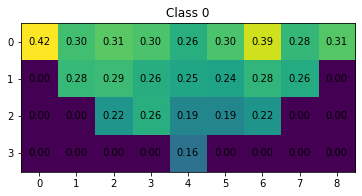

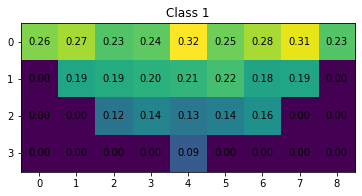

In [10]:
nnv = NNVisualizer(x, y, model)
nnv.image_plotter()